# ***IMPORTING THE LIBRARIES***

In [58]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.wcs import WCS
import bdsf
import os

Reading the dataset

In [59]:
input_fits = 'Abell_209_aFix_pol_I_15arcsec_fcube_cor.fits'
output_dir = './output'
os.makedirs(output_dir, exist_ok=True)
fits_file = 'abell_209.fits' 
#catalog_path = os.path.join(output_dir, 'abell_133.pybdsf.srl.fits')

In [9]:
print("Decompressing the FITS file...")
!gunzip -f Abell_133_aFix_pol_I_15arcsec_5pln_cor.fits.gz 2>/dev/null || echo "Warning: .gz file not found or already decompressed."


Decompressing the FITS file...


In [60]:
astro_data = fits.open('Abell_209_aFix_pol_I_15arcsec_fcube_cor.fits')

In [61]:
astro_data.info()

Filename: Abell_209_aFix_pol_I_15arcsec_fcube_cor.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     100   (3617, 3617, 12, 1)   float32   
  1  History       1 BinTableHDU     13   79R x 1C   [70A]   


In [62]:
astro_data

image_data = astro_data[0].data

Since the radio images can be quite large and high-dimentional i.e 4D . We have to slice them up in 2D for plotting and be able to be interpreted by PDSF. So we analyse a certain proportion of the image so that we can focus on and process faster .

In [63]:
# Creating a new FITS HDu file with the cropped data and
# Cropping to a 1000x1000 pixel region (center of the image)
data = image_data[0, 0, :, :]
#data = image_data # We can change sections we want to analyze.
# Create a new FITS HDU with the cropped data
hdu = fits.PrimaryHDU(data)
hdu.header = astro_data[0].header  # Copy the original header



In [64]:
# setting the header to reflect the new 2D shape to enable plotting ...
hdu.header['NAXIS'] = 2

Lets plot the image we have 

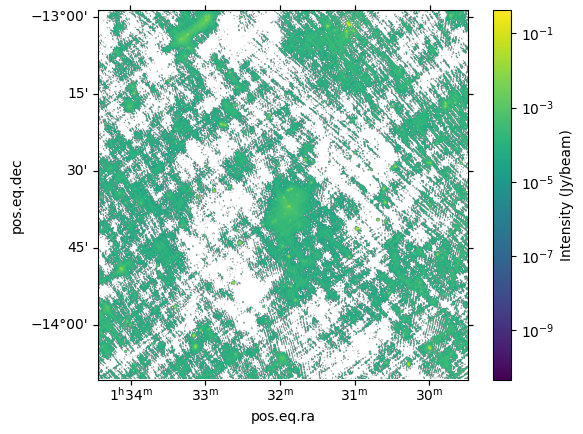

In [65]:
wcs = WCS(astro_data[0].header, naxis=2)
fig = plt.figure()
ax = fig.add_subplot(111, projection=wcs)
im = ax.imshow(data, cmap='viridis', norm='log')
plt.colorbar(im, ax=ax, label='Intensity (Jy/beam)')

In [66]:
if 'CRVAL3' in hdu.header:
    hdu.header['RESTFREQ'] = hdu.header['CRVAL3']  # Use CRVAL3 as an approximate frequency
    print(f"Added RESTFREQ = {hdu.header['RESTFREQ']} Hz to header.")

# Remove extra axis keywords if they exist
if 'NAXIS3' in hdu.header:
    del hdu.header['NAXIS3']
if 'NAXIS4' in hdu.header:
    del hdu.header['NAXIS4']

# Thoroughly removing all WCS-related keywords for the 3rd and 4th axes
for keyword in list(hdu.header.keys()):
    if any(keyword.startswith(prefix) for prefix in ['CRPIX3', 'CRVAL3', 'CDELT3', 'CTYPE3',
                                                    'CRPIX4', 'CRVAL4', 'CDELT4', 'CTYPE4']):
        del hdu.header[keyword]

# fixing this to be PyBDSF format which it expects
if 'CTYPE1' in hdu.header and 'CTYPE2' in hdu.header:
    
    hdu.header['CTYPE1'] = 'RA---SIN'  # Right Ascension
    hdu.header['CTYPE2'] = 'DEC--SIN'  # Declination
else:
    print("Warning: CTYPE1 or CTYPE2 missing in header. WCS may not work correctly.")

Added RESTFREQ = 1283791015.625 Hz to header.


In [67]:
# Dumping the cropped data to a new FITS file
hdu.writeto(fits_file, overwrite=True)  
print(f"FITS file saved as: {fits_file}")

FITS file saved as: abell_209.fits


##                           Processing pipeline for PyBDSF 

In [69]:
try:
    full_hdu = fits.open(fits_file)
    print("\nContents of FITS file:")
    print("data shape:", full_hdu[0].data.shape)
    print("header:")
    for key, value in full_hdu[0].header.items():
        print(f"{key:<8} = {value}")
    full_hdu.close()
except Exception as e:
    print(f"Error inspecting cropped FITS file: {e}")
    raise
try:
    img = bdsf.process_image("abell_209.fits",
                             mean_map='zero',
                             rms_box=(50, 20),  # Can be tuned but this was tuned for the mini abell133 fits
                             thresh_isl=4.0,    # Adjusted to more reasonable values
                             thresh_pix=5.0,
                             verbose=True)  # verbose output for debugging
except Exception as e:
    print("PyBDSF failed with error:", e)
    raise

--> Opened 'abell_209.fits'
Image size .............................. : (3617, 3617) pixels
Number of channels ...................... : 1
Number of Stokes parameters ............. : 1
Beam shape (major, minor, pos angle) .... : (4.16667e-03, 4.16667e-03, 0.0) degrees



Contents of FITS file:
data shape: (3617, 3617)
header:
SIMPLE   = True
BITPIX   = -32
NAXIS    = 2
NAXIS1   = 3617
NAXIS2   = 3617
EXTEND   = True
COMMENT  =   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT  =   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H
CTYPE1   = RA---SIN
CDELT1   = -0.0003317767
CRPIX1   = 1809.0
CROTA1   = 0.0
CRVAL1   = 22.98950361110778
CTYPE2   = DEC--SIN
CDELT2   = 0.0003317767
CRPIX2   = 1809.0
CROTA2   = 0.0
CRVAL2   = -13.57629805555667
CROTA3   = 0.0
CROTA4   = 0.0
OBSRA    = 22.98958333333
OBSDEC   = -13.57638888889
OBJECT   = A209
TELESCOP = MeerKAT
INSTRUME = MeerKAT
OBSERVER = Sharmila
DATE-OBS = 2018-10-03
DATE-MAP = 2020-09-07
ORIGIN   = Obit
EPOCH    = 2000.0
EQUINOX  = 2000.0
DATAMAX  = 2.69385409
DATAMIN  = -10.5041075
BUNIT    = JY/BEAM
ALTRPIX  = 1.0
CLEANBMJ = 0.004166667
CLEANBMN = 0.004166667
CLEANBPA = 0.0
CLEANNIT = 32770
DO3D     = 1
XPXOFF   = 0.0
YPXOFF   = 0.0
NTERM    = 0
NSPE

Frequency of image ...................... : 1283.791 MHz
Number of blank pixels .................. : 8 (0.0%)
Flux from sum of (non-blank) pixels ..... : 2.486 Jy
--> Calculating background rms and mean images
Using user-specified rms_box ............ : (50, 20) pixels
--> Variation in rms image significant
--> Using 2D map for background rms
--> Using constant background mean
Min/max values of background rms map .... : (2.20e-05, 1.81e-03) Jy/beam
Value of background mean ................ : 0.0 Jy/beam
--> Expected 5-sigma-clipped false detection rate < fdr_ratio
--> Using sigma-clipping ('hard') thresholding
Minimum number of pixels per island ..... : 59
Number of islands found ................. : 537
stty: 'standard input': Inappropriate ioctl for device


Fitting isl # 0 ; # pix =  120 ; size =  1.3429417710403413
Entering fit_island in verbose mode
Initializing, ini_gausfit is default gaul = [(0.0011825122637674212, 3, 7, np.float64(5.8664838486923285), np.float64(5.333167135174843), np.float64(90.0))] ngmax = 1
In Gaussian flag loop, iter = 1
Greetings from fit_iter
About to call C++ wrapper
Returned from the fit
Calling flag_gaussians
Leaving flag_gaussians
Preparing to return
Number of good Gaussians: 1
Number of flagged Gaussians: 0
Fitting isl # 1 ; # pix =  183 ; size =  2.04798620083652
Entering fit_island in verbose mode
Initializing, ini_gausfit is default gaul = [(0.0009164128568954766, 6, 9, np.float64(5.8664838486923285), np.float64(5.333167135174843), np.float64(90.0))] ngmax = 1
In Gaussian flag loop, iter = 1
Greetings from fit_iter
About to call C++ wrapper
Returned from the fit
Calling flag_gaussians
Leaving flag_gaussians
Preparing to return
Number of good Gaussians: 1
Number of flagged Gaussians: 0
status: 1  code: 3

/users/vutomi/.local/lib/python3.10/site-packages/bdsf/gausfit.py:806: RuntimeWarning: overflow encountered in cast
  if A < opts.flag_minsnr*thr:


Leaving flag_gaussians
In Gaussian flag loop, iter = 2
Greetings from fit_iter
About to call C++ wrapper
Returned from the fit
Calling flag_gaussians
Leaving flag_gaussians
In Gaussian flag loop, iter = 3
Greetings from fit_iter
About to call C++ wrapper
Returned from the fit
Calling flag_gaussians
Leaving flag_gaussians
In Gaussian flag loop, iter = 4
Greetings from fit_iter
About to call C++ wrapper
Returned from the fit
Calling flag_gaussians
Leaving flag_gaussiansstatus: 1  code: 1  Fev/Jev: 25/16  chi2(/dp): 1.57974e-08(8.10121e-11)  LMDER
status: 1  code: 2  Fev/Jev: 17/1  chi2(/dp): 1.57973e-08(8.1012e-11)  LMDER
status: 1  code: 1  Fev/Jev: 10/8  chi2(/dp): 1.57974e-08(8.10121e-11)  LMDER
status: 1  code: 1  Fev/Jev: 2/1  chi2(/dp): 1.57974e-08(8.10121e-11)  LMDER
status: 1  code: 1  Fev/Jev: 10/8  chi2(/dp): 1.57974e-08(8.10121e-11)  LMDER
status: 1  code: 1  Fev/Jev: 2/1  chi2(/dp): 1.57974e-08(8.10121e-11)  LMDER
status: 1  code: 1  Fev/Jev: 10/8  chi2(/dp): 1.57974e-08(8.10

Total number of Gaussians fit to image .. : 575
Total flux density in model ............. : 2.548 Jy
stty: 'standard input': Inappropriate ioctl for device
--> Grouping Gaussians into sources
Number of sources formed from Gaussians   : 550
    Island #32 (x=235, y=1984): fit with 1 Gaussian with flag = 288
    Island #203 (x=1256, y=2690): fit with 1 Gaussian with flag = 256
    Island #216 (x=1331, y=2609): fit with 1 Gaussian with flag = 256
    Island #298 (x=1855, y=1408): fit with 1 Gaussian with flag = 276
    Island #305 (x=1868, y=1429): fit with 1 Gaussian with flag = 380
    Island #316 (x=1930, y=1498): fit with 1 Gaussian with flag = 92
    Island #318 (x=1912, y=1255): fit with 1 Gaussian with flag = 256
    Island #334 (x=2016, y=1689): fit with 1 Gaussian with flag = 382
    Island #346 (x=2072, y=3316): fit with 1 Gaussian with flag = 256
    Island #347 (x=2071, y=3373): fit with 1 Gaussian with flag = 256
    Island #390 (x=2267, y=3298): fit with 1 Gaussian with flag

In [ ]:
# Saving the detected sources to a catalog file . 
img.write_catalog(outfile=catalog_path, format='fits', clobber=True)


In [70]:
# Load the catalog to verify
catalog = fits.open("abell_209.pybdsm.srl.fits")
sources = catalog[1].data
print(f"Number of detected sources: {len(sources)}")
print("Source catalog columns:", sources.columns.names)

Number of detected sources: 399
Source catalog columns: ['Source_id', 'Isl_id', 'RA', 'E_RA', 'DEC', 'E_DEC', 'Total_flux', 'E_Total_flux', 'Peak_flux', 'E_Peak_flux', 'RA_max', 'E_RA_max', 'DEC_max', 'E_DEC_max', 'Maj', 'E_Maj', 'Min', 'E_Min', 'PA', 'E_PA', 'Maj_img_plane', 'E_Maj_img_plane', 'Min_img_plane', 'E_Min_img_plane', 'PA_img_plane', 'E_PA_img_plane', 'DC_Maj', 'E_DC_Maj', 'DC_Min', 'E_DC_Min', 'DC_PA', 'E_DC_PA', 'DC_Maj_img_plane', 'E_DC_Maj_img_plane', 'DC_Min_img_plane', 'E_DC_Min_img_plane', 'DC_PA_img_plane', 'E_DC_PA_img_plane', 'Isl_Total_flux', 'E_Isl_Total_flux', 'Isl_rms', 'Isl_mean', 'Resid_Isl_rms', 'Resid_Isl_mean', 'S_Code']


These will be used  later to locate soureces with RA and DEC for sky coordinates for computer vision models . 

In [71]:
# Handling NaNs in the cropped data for plotting
image_2d = np.nan_to_num(data, nan=np.nanmin(data))

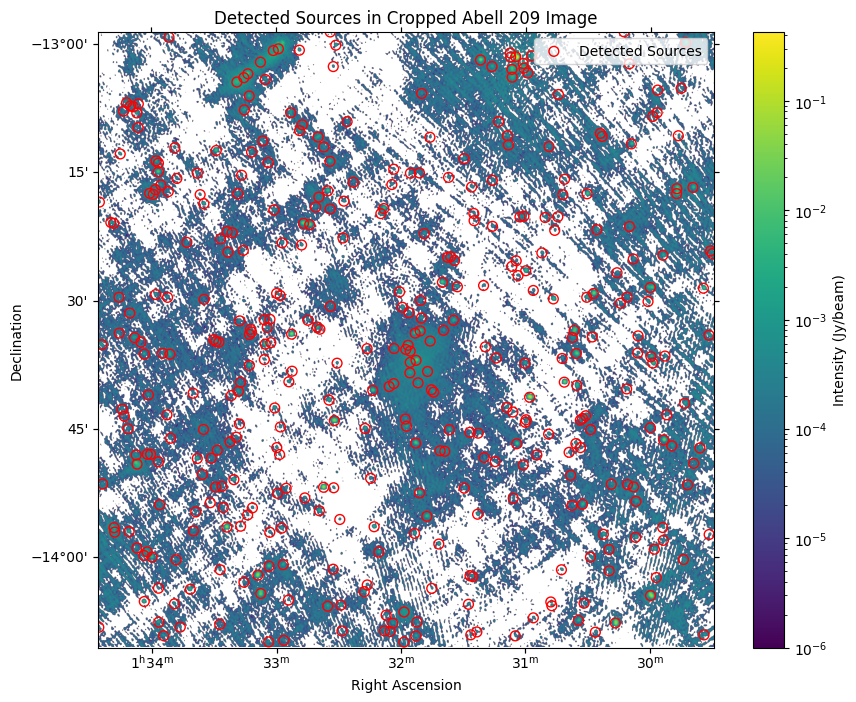

In [73]:
# Plot the image with PYBDSF detected sources.
wcs = WCS(hdu.header, naxis=2)  # Force 2D WCS
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=wcs)
im = ax.imshow(image_2d, cmap='viridis', norm='log', vmin=1e-6)  # Plot the image data
plt.colorbar(im, ax=ax, label='Intensity (Jy/beam)')

# Overlaying with detected sources
if 'RA' in sources.columns.names and 'DEC' in sources.columns.names:
    ra = sources['RA']
    dec = sources['DEC']
elif 'RAJ2000' in sources.columns.names and 'DEJ2000' in sources.columns.names:
    ra = sources['RAJ2000']
    dec = sources['DEJ2000']
else:
    print("Error: RA and DEC columns not found in catalog. Available columns:", sources.columns.names)
    raise KeyError("RA and DEC columns not found in catalog.")

ax.scatter(ra, dec, transform=ax.get_transform('world'), marker='o',
           edgecolor='red', facecolor='none', s=50, label='Detected Sources')

ax.coords['ra'].set_axislabel('Right Ascension')
ax.coords['dec'].set_axislabel('Declination')
plt.title('Detected Sources in Cropped Abell 209 Image')
plt.legend()
plt.show()

# Clean up
astro_data.close()
catalog.close()